# Section F. Multiclass Perceptron
## Multiclass Perceptron


### Dataset Loading

In [1]:
options(warn=-1)
library(MASS)
library(ggplot2)
library(reshape2)
set.seed(1234)

In [2]:
train.data.csv <- read.csv("Task1D_train.csv",head=TRUE)
test.data.csv <- read.csv("Task1D_test.csv",head=TRUE)

# Following function is used to separate input variables and class labels
dataAndLabels <- function(data){
    nr = dim(data)[1]
    nc = dim(data)[2]
    x = data[1:nr,1:(nc-1)]
    y = data[1:nr,nc]
    return (list("x" = x, "y" = y))
}


In [3]:
train.data <- dataAndLabels(train.data.csv)
test.data <- dataAndLabels(test.data.csv)

## Basis function Phi
Phi <- as.matrix(cbind(1, train.data$x)) # add a column of one's
Phi.test <- as.matrix(cbind(1, test.data$x))

In [4]:
# Initialization of parameters
eta <- 0.09 # learn rate
tau.max <- 100 # max number of iterations
epsilon <- 0.001 # stop criterion

tau <- 1 # iteration counter 
terminate <- FALSE # termination status

In [5]:
# Create a weight vector for classes C1, C2, and C3

W = list() # list to hold weight vectors for C1, C2, and C3

W$C1 <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # Empty matrix for C1 class's weight vector
W$C1[1,] <- runif(ncol(Phi)) # Random initial values for weight vector

W$C2 <- matrix(,nrow=tau.max, ncol=ncol(Phi))
W$C2[1,] <- runif(ncol(Phi))

W$C3 <- matrix(,nrow=tau.max, ncol=ncol(Phi))
W$C3[1,] <- runif(ncol(Phi))

x = "C1"
W[[x]][1,]

#Empty dataset to store test error for every mini batch
errors <- data.frame('pnt' = numeric(), 'miniBatch' = numeric(), 'testError' = numeric(), 'tau' = numeric())
train_er <- data.frame()

[1] 0.1137034 0.6222994 0.6092747 0.6233794 0.8609154

In [6]:
# predict_class function
class_predict <- function(Phi, tau){
    C1_score = W$C1[tau,] %*% Phi
    C2_score = W$C2[tau,] %*% Phi
    C3_score = W$C3[tau,] %*% Phi

    prediction = max(C1_score, C2_score, C3_score) # make prediction based on the highest score
    
    # return for predicted class
    if(prediction == C1_score)
        return ('C1')
    if(prediction == C2_score)
        return ('C2')
    if(prediction == C3_score)
        return ('C3')    
}

In [7]:
pnt = 1

# Main Loop (Step 2):
while(!terminate){
    # resuffling train data and associated labels:
    train.index <- sample(1:nrow(train.data$x), replace = FALSE)
    train.data$y <- train.data$y[train.index]
    Phi <- Phi[train.index,]
    
    
    er_train = 0
    for (i in train.index){
        if (tau == tau.max) {break}
        
        # call predict_class function to make a prediction
        predictedClass = class_predict(Phi[i,], tau)
        trueClass = toString(train.data$y[i])

        
        
        if (predictedClass != trueClass){
            # update tau counter
            tau <- tau +1
            er_train = er_train + 1 # update training error count
            
            # update the weights
            W[[trueClass]][tau,] = W[[trueClass]][tau-1,] + (eta * Phi[i,])
            W[[predictedClass]][tau,] = W[[predictedClass]][tau-1,] - (eta * Phi[i,])
            
            #updating vector for remaining class
            remainingClass = setdiff(c('C1', 'C2', 'C3'), c(trueClass, predictedClass)) # select the remaining class
            W[[remainingClass]][tau,] = W[[remainingClass]][tau-1,]
        }
        
        if (pnt %% 5 == 0){
            error = 0 # to count number of mispredictions

            for (j in 1:nrow(test.data$x)){
                
                prediction = class_predict(Phi.test[j,], tau)
                if (prediction != toString(test.data$y[j])){
                    error = error + 1
                }
            }
            # compute error for the current batch
            error = error / nrow(test.data$x)
            # save the data frame
            errors[nrow(errors)+1, 'pnt'] = pnt
            errors[nrow(errors), 'miniBatch'] = pnt/5 
            errors[nrow(errors), 'testError'] = error
            errors[nrow(errors), 'tau'] = tau          

        }
        pnt = pnt + 1
        
    }

    # decrease eta:
    eta = eta * 0.99
    
    # calculate training error
    train_er[nrow(train_er)+1, 1] = er_train/ length(train.index)
    
    # check termination conditions
    if (tau >= tau.max){
        terminate <- TRUE
    }
    else if (nrow(train_er) >= 2 && train_er[nrow(train_er),1] < 0.03){
        # check if there is atleast two recorded training errors and training error is less than 3%
        improvement = train_er[nrow(train_er),1] - train_er[nrow(train_er)-1, 1]
        terminate = improvement < epsilon # terminate if the improvement is minimal
        }
}

W$C1 <- W$C1[1:tau,]
W$C2 <- W$C2[1:tau,]
W$C3 <- W$C3[1:tau,]

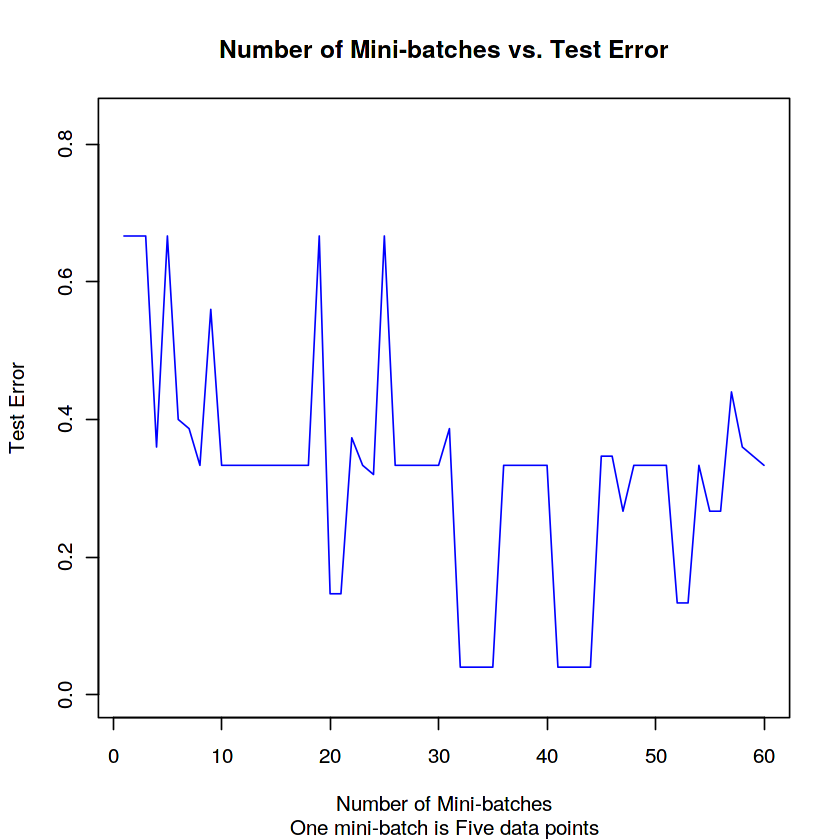

In [8]:
#plot to show number of mini batches vs Test error
plot(x = errors[ ,'miniBatch'], y =errors[ ,'testError'], ylim = c(0,max(errors[ ,'testError']*1.25)), type = 'l', 
     col = 'blue', main = "Number of Mini-batches vs. Test Error", xlab = "Number of Mini-batches", ylab = "Test Error",
     sub = "One mini-batch is Five data points")
errors.m <- melt(as.data.frame(errors), id='miniBatch')